In [49]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import collections
import os
import random
import numpy as np
from tqdm import tqdm
import sys, email
import pandas as pd
import math
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
##Download Enron CSV from kaggle###

!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
#Upload your kaggle Json to pull kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xaarons","key":"1cebcd12abf74318a09f007c084bad0b"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jhbros/enron-email-dataset
!ls

 91% 289M/319M [00:04<00:00, 53.1MB/s]
100% 319M/319M [00:04<00:00, 71.5MB/s]
enron-email-dataset.zip  kaggle.json  sample_data


In [5]:
import pandas as pd
#########################################################
# Load Enron dataset
#########################################################
emails_df = pd.read_csv('/content/enron-email-dataset.zip', compression='zip', header=0, sep=',', quotechar='"')
print(emails_df.shape)
emails_df.head()

(517401, 8)


,Message-ID,Date,From,To,Subject,Message,Cc,Bcc
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,Here is our forecast\n\n \n,NaN,NaN
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,NaN,NaN
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!\n,NaN,NaN
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45. \n,NaN,NaN


In [6]:
# Run this cell if you have the enron file locally
# #########################################################
# # Load Enron dataset
# #########################################################
# emails_df = pd.read_csv('enron.csv', header=0, sep=',', quotechar='"')
# emails_df.head()

In [7]:
emails_sample_df = emails_df.copy()
emails_sample_df.fillna('', inplace = True)

In [8]:
# clean up subject line
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.lower()
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace('re:', ' ')
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace('fw:', ' ')
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'[^a-z]', ' ')
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'\s+', ' ')


# clean up content line
emails_sample_df['Message'] = emails_sample_df['Message'].str.lower()
emails_sample_df['Message'] = emails_sample_df['Message'].str.replace(r'[^a-z]', ' ')
emails_sample_df['Message'] = emails_sample_df['Message'].str.replace('fw:', ' ')
emails_sample_df['Message'] = emails_sample_df['Message'].str.replace(r'\s+', ' ')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


In [9]:
# create sentence list
emails_text = (emails_sample_df["Subject"] + ". " + emails_sample_df["Message"]).tolist()

In [10]:
sentences = ' '.join([str(i) for i in emails_text])
words = sentences.split()

print('Data size', len(words))


Data size 142969566


In [11]:
# get unique words and map to glove set
print('Unique word count', len(set(words))) 


Unique word count 595623


In [12]:
# drop rare words
vocabulary_size = 50000

In [13]:
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in tqdm(words):
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

100%|██████████| 142969566/142969566 [00:59<00:00, 2397318.93it/s]


In [14]:
del words  
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 2653112], ('the', 5679772), ('to', 4059185), ('and', 2589752), ('of', 2388302)]
Sample data [115, 145, 11, 53, 2020, 115, 4033, 2, 25, 5] ['.', 'here', 'is', 'our', 'forecast', '.', 'traveling', 'to', 'have', 'a']


In [15]:
####################################################################
#Download Glove 
####################################################################
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-19 21:54:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-19 21:54:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-19 21:54:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [16]:
GLOVE_DATASET_PATH = 'glove.6B.100d.txt'
 
embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    if word in dictionary:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()

400000it [00:03, 130361.04it/s]


In [17]:
####################################################################
# find matches with glove 
####################################################################

from contextlib import suppress
from tqdm import tqdm
import string


embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    if word in dictionary:
        with suppress(ValueError):
            coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()




print('Found %s word vectors matching enron data set.' % len(embeddings_index))
print('Total words in GloVe data set: %s' % word_counter)


400000it [00:04, 96504.60it/s] 

Found 38274 word vectors matching enron data set.
Total words in GloVe data set: 400000


In [18]:
#########################################################
# Check out some clusters
#########################################################

# create a dataframe using the embedded vectors and attach the key word as row header
enrond_dataframe = pd.DataFrame(embeddings_index)
enrond_dataframe = pd.DataFrame.transpose(enrond_dataframe)
 
# See what it learns and look at clusters to pull out major themes in the data
CLUSTER_SIZE = 500 
# cluster vector and investigate top groups
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUSTER_SIZE)
cluster_make = kmeans.fit_predict(enrond_dataframe)

labels = kmeans.predict(enrond_dataframe)
import collections
cluster_frequency = collections.Counter(labels)
print(cluster_frequency)
cluster_frequency.most_common()

clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(list(enrond_dataframe.index)[n])
    else:
        clusters[item] = [list(enrond_dataframe.index)[n]]
    n +=1

for k,v in cluster_frequency.most_common(500):
    print('\n\n')
    print('Cluster:', k)
    print (' '.join(clusters[k]))


Counter({461: 600, 347: 453, 284: 341, 407: 309, 274: 303, 412: 299, 327: 267, 67: 255, 107: 252, 187: 230, 48: 226, 125: 222, 292: 219, 19: 208, 290: 207, 157: 202, 159: 193, 28: 183, 387: 183, 227: 181, 365: 179, 498: 175, 12: 172, 261: 171, 239: 163, 426: 162, 337: 161, 201: 155, 443: 155, 427: 151, 37: 149, 209: 147, 89: 147, 415: 145, 119: 142, 450: 140, 251: 140, 453: 138, 22: 138, 10: 137, 204: 137, 77: 137, 196: 136, 444: 136, 129: 136, 310: 135, 132: 134, 382: 133, 70: 133, 430: 133, 452: 132, 384: 131, 185: 129, 166: 127, 391: 123, 167: 121, 200: 121, 224: 121, 189: 119, 428: 118, 197: 117, 50: 116, 44: 115, 161: 115, 323: 113, 249: 113, 141: 112, 134: 112, 493: 112, 454: 112, 195: 110, 51: 110, 26: 109, 17: 108, 93: 108, 65: 107, 238: 107, 85: 106, 286: 106, 8: 104, 480: 104, 413: 102, 212: 102, 256: 101, 299: 101, 221: 101, 32: 101, 325: 101, 183: 100, 186: 100, 110: 99, 177: 98, 222: 97, 171: 97, 366: 97, 128: 97, 296: 96, 56: 96, 160: 96, 374: 96, 253: 95, 399: 95, 2: 95,

In [19]:
####################################################
# Load master clusters for all six deparatments
####################################################
 
LEGAL=['affirmed','alleged','appeal','appealed','appeals','appellate','attorney','attorneys','bankruptcy','case','cases','charged','charges','civil','claim','claims','complaint','constitutional','constitutionality','constitutionally','copyright','counsel','court','courts','criminal','damages','decision','decree','decrees','defendants','denied','dispute','dissented','dissenting','enforcement','federal','filed','filing','invalidate','invalidated','judge','judgement','judges','judgment','judgments','judicial','judiciary','jurisdiction','jurisprudence','justice','justices','law','laws','lawsuit','lawsuits','lawyer','lawyers','legal','legality','legally','litigation','overrule','overruled','overturn','overturned','overturning','plaintiff','precedent','precedents','prosecutorial','reversed','rights','ruled','ruling','rulings','settlement','settlements','sue','supreme','tribunal','tribunals','unanimous','unconstitutional','upheld','uphold','upholding','upholds','verdict','violation']

COMMUICATIONS=['accessed','ads','alphabetical','alphabetically','archive','archived','archives','below','bookmark','bookmarked','bookmarks','browse','browsing','calendar','catalog','categories','categorized','category','chart','charts','check','classified','classifieds','codes','compare','content','database','details','directories','directory','domain','domains','downloadable','entries','favorites','feeds','free','genealogy','homepage','homepages','hosting','index','indexed','indexes','info','information','keyword','keywords','library','link','linking','links','list','listed','listing','listings','lists','locate','locator','maps','online','page','pages','peruse','portal','profile','profiles','rated','related','resource','results','search','searchable','searched','searches','searching','selections','signup','site','sites','sorted','statistics','stats','subscribing','tagged','testimonials','titles','updated','updates','via','web','webmaster','webpage','webpages','website','websites','wishlist','accountant','careers','clerical','contracting','department','employed','employee','employees','employer','employers','employment','experienced','freelance','fulltime','generalist','hire','hired','hires','hiring','hourly','intern','interviewing','job','jobs','labor','labour','managerial','manpower','office','paralegal','personnel','placements','positions','profession','professional','professions','qualified','receptionist','recruit','recruiter','recruiters','recruiting','recruitment','resume','resumes','salaried','salaries','salary','seeking','skilled','staff','staffing','supervisor','trainee','vacancies','vacancy','worker','workers','workforce','workplace']

SECURITY_SPAM_ALERTS=['abducted','accidental','anthrax','anti','antibiotic','antibiotics','assaulted','attacked','attacker','attackers','auth','authenticated','authentication','avoid','avoidance','avoided','avoiding','bacteria','besieged','biometric','bioterrorism','blocking','boarded','bodyguards','botched','captive','captives','captors','captured','chased','commandeered','compromised','confronted','contagious','cornered','culprit','damage','damaging','danger','dangerous','dangers','destroying','destructive','deterrent','detrimental','disruptive','electrocuted','eliminate','eliminating','encroachment','encrypted','encryption','epidemic','escape','escaped','escapee','escaping','expose','exposed','exposing','fatally','feared','fled','flee','fleeing','flu','foiled','freed','germ','germs','guarded','guarding','guards','gunning','hapless','harassed','harm','harmful','harmless','harsh','hepatitis','hid','hijacked','hijacker','hijackers','hiv','hostage','hostages','hunted','immune','immunity','immunization','imprisoned','improper','inadvertent','infect','infected','infecting','infection','infections','infectious','infects','injuring','intentional','interference','interfering','intruders','intrusion','intrusive','invaded','isolates','kidnapped','limiting','login','logins','logon','lured','malaria','malicious','masked','minimise','minimize','minimizing','misuse','mite','mitigating','mosquito','motorcade','nuisance','offending','outbreak','overrun','passcode','password','passwords','plaintext','pneumonia','policeman','potentially','prevent','prevented','preventing','prevents','prone','protect','protected','protecting','protection','protects','quarantine','raided','ransom','raped','refuge','removing','rescued','rescuing','resisting','risks','robbed','runaway','safeguard','secret','secrets','seized','sensitive','server','shielding','smallpox','spam','spores','stolen','stormed','strain','strains','stranded','strep','summoned','susceptible','swine','threat','threatened','threatening','threats','thwarted','tortured','trapped','unaccounted','undesirable','unhealthy','unidentified','unintended','unintentional','unnamed','unnecessary','unprotected','unsafe','unwanted','unwelcome','user','username','vaccine','vaccines','villagers','viral','virus','viruses','vulnerability','vulnerable','whereabouts','whooping','withstand','wounded']

SUPPORT=['ability','acrobat','adobe','advantage','advice','aid','aids','aim','alternatives','app','apps','ares','assist','autodesk','avs','benefits','best','boost','bring','bringing','build','cad','ccna','cellphone','challenge','choices','choosing','citrix','compatible','computer','computers','conferencing','console','consoles','continue','contribute','corel','create','creating','crucial','desktop','desktops','develop','devices','digital','discover','discuss','ease','easier','educate','effective','effectively','effort','electronic','electronics','encarta','encourage','energy','enhance','ensure','essential','eudora','experience','explore','finding','future','gadget','gadgets','gizmos','goal','groupwise','guide','guides','handhelds','handset','handsets','hardware','help','helpful','helping','helps','hopes','ideas','idm','important','improve','interactive','internet','introduce','intuit','invaluable','ios','join','kiosk','kiosks','laptops','lead','learn','lightwave','mac','machines','macintosh','macromedia','maintain','manage','mcafee','meet','messaging','microsoft','mobile','monitors','morpheus','mouse','mice','multimedia','natural','needed','needs','netware','networked','networking','norton','notebooks','novell','ocr','oem','offline','office','opportunity','our','peripherals','personal','pgp','phone','phones','photoshop','plan','plans','portables','potential','practical','prepare','pros','quark','quicken','realplayer','recommend','remotely','resources','safe','save','saving','sbe','screens','serve','servers','share','sharing','software','solve','sophos','spb','spss','ssg','standalone','support','symantec','task','tech','telephones','televisions','their','tips','to','together','trojan','useful','users','valuable','veritas','virtual','visio','vista','vital','vmware','ways','wga','whs','winzip','wordperfect','working','workstation','workstations','xp','xpress']

ENERGY_DESK=['amps','baseload','bhp','biomass','blowers','boiler','boilers','btu','btus','burners','cc','cfm','chiller','chillers','cogen','cogeneration','compressors','conditioner','conditioners','conditioning','coolers','cooling','cranking','desalination','diesels','electric','electrical','electricity','electricty','electrification','energy','engine','engines','furnace','furnaces','gasification','generators','genset','geothermal','gigawatt','gpm','heat','heater','heaters','heating','horsepower','hp','hvac','hydro','hydroelectric','hydroelectricity','hydropower','idle','idling','ignition','intertie','kilovolt','kilowatt','kilowatts','kw','kwh','liter','megawatt','megawatts','microturbines','motor','motors','mph','municipally','peaker','photovoltaic','photovoltaics','power','powered','powerplant','powerplants','psi','psig','reactors','redline','refrigerated','refrigeration','renewable','renewables','repower','retrofits','retrofitting','revs','rpm','siting','solar','substation','substations','switchgear','switchyard','temperatures','terawatt','thermo','thermoelectric','thermostat','thermostats','throttle','torque','turbine','turbines','turbo','ventilation','volt','volts','weatherization','whp','wind','windmill','windmills','windpower']

SALES_DEPARTMENT=['accounting','advertised','affordable','auction','auctions','audited','auditing','bargain','bargains','bidding','billable','billed','billing','billings','bookkeeping','bought','brand','branded','brands','broker','brokerage','brokers','budgeting','bulk','buy','buyer','buyers','buying','buys','cancel','cancellation','cancellations','cancelled','cardholders','cashback','cashflow','chain','chargeback','chargebacks','cheap','cheaper','cheapest','checkbook','checkout','cheque','cheques','clearance','closeout','consignment','convenience','cosmetics','coupon','coupons','deals','debit','debited','debits','deducted','delivery','deposit','discontinued','discount','discounted','discounts','distributor','ebay','escrow','expensive','export','exported','exporter','exporters','exporting','exports','fee','fees','goods','gratuities','gratuity','groceries','grocery','import','importation','imported','importer','importers','importing','imports','incur','inexpensive','instore','inventory','invoice','invoiced','invoices','invoicing','item','items','lease','ledger','ledgers','manufacturer','marketed','merchandise','merchant','negotiable','nonmembers','nonrefundable','ordering','origination','outlets','overage','overdraft','overstock','owner','owners','payable','payables','payment','payroll','postage','postmarked','premium','prepaid','prepay','prepayment','price','priced','prices','pricey','pricing','product','products','proforma','purchase','purchased','purchaser','purchases','purchasing','rebate','rebook','rebooked','rebooking','receipts','receivable','receivables','reconciliations','recordkeeping','redeem','redeemable','refund','refundable','refunded','refunding','refunds','remittance','resell','reselling','retail','retailer','retailing','sale','sell','seller','sellers','selling','sells','shipment','shipments','shipped','shipper','shippers','shipping','shop','shopped','shopping','shops','sold','spreadsheets','store','stores','supermarket','supermarkets','superstore','supplier','supplies','supply','surcharge','surcharges','timesheet','timesheets','transaction','upfront','vending','vendor','verifications','voucher','vouchers','warehouse','warehouses','wholesale','wholesaler','wholesaling']

In [20]:
# boost bags with cosine distance from full glove data set
from tqdm import tqdm
import string
embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    # difference here as we don't intersect words, we take most of them
    if (word.islower() and word.isalpha()): # work with smaller list of vectors
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()

400000it [00:07, 54360.76it/s]


In [21]:
# create a dataframe using the embedded vectors and attach the key word as row header
glove_dataframe = pd.DataFrame(embeddings_index)
glove_dataframe = pd.DataFrame.transpose(glove_dataframe)

In [22]:
departments = [LEGAL, COMMUICATIONS, SECURITY_SPAM_ALERTS, SUPPORT, ENERGY_DESK, SALES_DEPARTMENT]

In [23]:
temp_matrix = pd.DataFrame(glove_dataframe)
import scipy
import scipy.spatial

In [24]:
vocab_boost_count = 5
for group_id in range(len(departments)):
    print('Working bag number:', str(group_id))
    glove_dataframe_temp = glove_dataframe.copy()
    vocab = []
    for word in departments[group_id]:
        print(word)
        vocab.append(word)
        cos_dist_rez = scipy.spatial.distance.cdist(temp_matrix, np.array(glove_dataframe.loc[word])[np.newaxis,:], metric='cosine')
        # find closest words to help
        glove_dataframe_temp['cdist'] = cos_dist_rez
        glove_dataframe_temp = glove_dataframe_temp.sort_values(['cdist'], ascending=[1])
        vocab = vocab + list(glove_dataframe_temp.head(vocab_boost_count).index)
    # replace boosted set to old department group and remove duplicates
    departments[group_id] = list(set(vocab))

Working bag number: 0
affirmed
alleged
appeal
appealed
appeals
appellate
attorney
attorneys
bankruptcy
case
cases
charged
charges
civil
claim
claims
complaint
constitutional
constitutionality
constitutionally
copyright
counsel
court
courts
criminal
damages
decision
decree
decrees
defendants
denied
dispute
dissented
dissenting
enforcement
federal
filed
filing
invalidate
invalidated
judge
judgement
judges
judgment
judgments
judicial
judiciary
jurisdiction
jurisprudence
justice
justices
law
laws
lawsuit
lawsuits
lawyer
lawyers
legal
legality
legally
litigation
overrule
overruled
overturn
overturned
overturning
plaintiff
precedent
precedents
prosecutorial
reversed
rights
ruled
ruling
rulings
settlement
settlements
sue
supreme
tribunal
tribunals
unanimous
unconstitutional
upheld
uphold
upholding
upholds
verdict
violation
Working bag number: 1
accessed
ads
alphabetical
alphabetically
archive
archived
archives
below
bookmark
bookmarked
bookmarks
browse
browsing
calendar
catalog
categories
cat

In [25]:
# save final objects to disk

import pickle
with open('full_bags.pk', 'wb') as handle:
    pickle.dump(departments, handle)

In [26]:
##################################################################### 
# Create features of word counts for each department in each email
#####################################################################
 

with open('full_bags.pk', 'rb') as handle:
    departments = pickle.load(handle)

# loop through all emails and count group words in each raw text
words_groups = []
for group_id in range(len(departments)):
    work_group = []
    print('Working bag number:', str(group_id))
    top_words = departments[group_id]
    for index, row in tqdm(emails_sample_df.iterrows()): 
        text = (row["Subject"] + " " + row["Message"]) 
        work_group.append(len(set(top_words) & set(text.split())))
    
    words_groups.append(work_group)

# count emails per category group and feature engineering

raw_text = []
subject_length = []
subject_word_count = []
content_length = []
content_word_count = []
is_am_list = []
is_weekday_list = []
group_LEGAL = []
group_COMMUICATIONS = []
group_SECURITY_SPAM_ALERTS = []
group_SUPPORT = []
group_ENERGY_DESK = []
group_SALES_DEPARTMENT = []
final_outcome = []

Working bag number: 0


517401it [00:58, 8898.87it/s]


Working bag number: 1


517401it [01:03, 8138.89it/s]


Working bag number: 2


517401it [01:21, 6340.31it/s]


Working bag number: 3


517401it [01:06, 7809.01it/s]


Working bag number: 4


517401it [01:00, 8540.83it/s]


Working bag number: 5


517401it [01:07, 7673.41it/s]


In [27]:
emails_sample_df.dropna(inplace=True)
emails_sample_df['Subject'].fillna('', inplace=True)
emails_sample_df['Date'] = pd.to_datetime(emails_sample_df['Date'], infer_datetime_format=True,errors = 'coerce',utc=True)
emails_sample_df.dropna(inplace=True)

In [28]:
import datetime 

counter = 0
for index, row in tqdm(emails_sample_df.iterrows()):
    raw_text.append([row["Subject"] + " " + row["Message"]])
    group_LEGAL.append(words_groups[0][counter])
    group_COMMUICATIONS.append(words_groups[1][counter]) 
    group_SECURITY_SPAM_ALERTS.append(words_groups[2][counter])
    group_SUPPORT.append(words_groups[3][counter])
    group_ENERGY_DESK.append(words_groups[4][counter])
    group_SALES_DEPARTMENT.append(words_groups[5][counter])
    outcome_tots = [words_groups[0][counter], words_groups[1][counter], words_groups[2][counter],
      words_groups[3][counter], words_groups[4][counter], words_groups[5][counter]] 
    final_outcome.append(outcome_tots.index(max(outcome_tots)))
    
    subject_length.append(len(row['Subject']))
    subject_word_count.append(len(row['Subject'].split()))
    content_length.append(len(row['Message']))
    content_word_count.append(len(row['Message'].split()))
    dt = row['Date']
    is_am = 'no'
    if (dt.time() < datetime.time(12)): is_am = 'yes'
    is_am_list.append(is_am)
    is_weekday = 'no'
    if (dt.weekday() < 6): is_weekday = 'yes'
    is_weekday_list.append(is_weekday)
    counter += 1

517400it [01:25, 6070.62it/s]


In [29]:
# add simple engineered features
training_set = pd.DataFrame({
              "raw_text":raw_text,
              "group_LEGAL":group_LEGAL,
              "group_COMMUICATIONS":group_COMMUICATIONS,
              "group_SECURITY_SPAM_ALERTS":group_SECURITY_SPAM_ALERTS,
              "group_SUPPORT":group_SUPPORT,
              "group_ENERGY_DESK":group_ENERGY_DESK,
              "group_SALES_DEPARTMENT":group_SALES_DEPARTMENT,
              "subject_length":subject_length,
              "subject_word_count":subject_word_count,
              "content_length":content_length,
              "content_word_count":content_word_count,
              "is_AM":is_am_list,
              "is_weekday":is_weekday_list,
              "outcome":final_outcome
              })

# remove all emails that have all zeros (i.e. not from any of required categories)
training_set = training_set[(training_set.group_LEGAL > 0) | 
              (training_set.group_COMMUICATIONS > 0) | 
              (training_set.group_SECURITY_SPAM_ALERTS > 0) |
              (training_set.group_SUPPORT > 0) |
              (training_set.group_ENERGY_DESK > 0) |
              (training_set.group_SALES_DEPARTMENT > 0)]
print(len(training_set))
# save extractions to file
training_set.to_csv('enron_classification_df.csv', index=False, header=True)

482868


In [30]:
model_ready_data = pd.read_csv('enron_classification_df.csv') 

# https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
# (60% - train set, 20% - validation set, 20% - test set)
df_train, df_test, df_val = np.split(model_ready_data.sample(frac=1), [int(.6*len(model_ready_data)), int(.8*len(model_ready_data))])

# Continuous base columns
content_length = tf.feature_column.numeric_column("content_length")
content_word_count = tf.feature_column.numeric_column("content_word_count")
subject_length = tf.feature_column.numeric_column("subject_length")
subject_word_count = tf.feature_column.numeric_column("subject_word_count")
group_LEGAL = tf.feature_column.numeric_column("group_LEGAL")
group_COMMUICATIONS = tf.feature_column.numeric_column("group_COMMUICATIONS")
group_SECURITY_SPAM_ALERTS = tf.feature_column.numeric_column("group_SECURITY_SPAM_ALERTS")
group_SUPPORT = tf.feature_column.numeric_column("group_SUPPORT")
group_ENERGY_DESK = tf.feature_column.numeric_column("group_ENERGY_DESK")
group_SALES_DEPARTMENT = tf.feature_column.numeric_column("group_SALES_DEPARTMENT")

content_length_bucket = tf.feature_column.bucketized_column(content_length, boundaries=[100, 200, 300, 400])
subject_length_bucket = tf.feature_column.bucketized_column(subject_length, boundaries=[10,15, 20, 25, 30])

# Categorical base columns
is_AM_sparse_column = tf.feature_column.categorical_column_with_vocabulary_list("is_AM", ["yes", "no"])
is_weekday_sparse_column = tf.feature_column.categorical_column_with_vocabulary_list("is_weekday", ["yes", "no"])

categorical_columns = [is_AM_sparse_column, is_weekday_sparse_column, content_length_bucket, subject_length_bucket] 

deep_columns = [content_length, content_word_count, subject_length, subject_word_count,
               group_LEGAL, group_COMMUICATIONS, group_SECURITY_SPAM_ALERTS, group_SUPPORT, 
               group_ENERGY_DESK, group_SALES_DEPARTMENT]

simple_columns = [group_LEGAL, group_COMMUICATIONS, group_SECURITY_SPAM_ALERTS, group_SUPPORT, 
              group_ENERGY_DESK, group_SALES_DEPARTMENT]

In [31]:
import tempfile
model_dir = tempfile.mkdtemp()
classifier = tf.estimator.DNNClassifier(feature_columns=simple_columns,
                                hidden_units=[20, 20],
                                n_classes=6,
                                model_dir=model_dir,)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpitlimkyz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
# Define the column names for the data sets.
COLUMNS = ['content_length',
 'content_word_count',
 'group_LEGAL',
 'group_COMMUICATIONS',
 'group_SECURITY_SPAM_ALERTS',
 'group_SUPPORT',
 'group_ENERGY_DESK',
 'group_SALES_DEPARTMENT',
 'is_AM',
 'is_weekday',
 'subject_length',
 'subject_word_count',
 'outcome']
LABEL_COLUMN = 'outcome'
CATEGORICAL_COLUMNS = ["is_AM", "is_weekday"]
CONTINUOUS_COLUMNS = ['content_length',
 'content_word_count',
 'group_LEGAL',
 'group_COMMUICATIONS',
 'group_SECURITY_SPAM_ALERTS',
 'group_SUPPORT',
 'group_ENERGY_DESK',
 'group_SALES_DEPARTMENT',
 'subject_length',
 'subject_word_count']

LABELS = [0, 1, 2, 3, 4, 5]

In [33]:
def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
  # Converts the label column into a constant Tensor.
    label = tf.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
    return feature_cols, label

In [34]:
def train_input_fn():
    return input_fn(df_train)

def eval_input_fn():
    return input_fn(df_test)

In [35]:
# After reading in the data, you can train and evaluate the model:

classifier.train(input_fn=train_input_fn, steps=200)
results = classifier.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))




Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpitlimkyz/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 591541.9, step = 0
INFO:tensorflow:global_step/sec: 50.8949
INFO:tensorflow:loss = 25465.006, step = 100 (1.966 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/

In [36]:
preds = list()
for idx, p in enumerate(classifier.predict(input_fn=lambda: input_fn(df_val))):
    preds.append(p['class_ids'][0])
    if idx == 96573:
        break

print('buckets found:',set(preds))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpitlimkyz/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
buckets found: {0, 1, 2, 3, 4, 5}


In [37]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Pastel1')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="Red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="Red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_val[LABEL_COLUMN], preds)


In [58]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [59]:
np.mean(recall)


0.9885120443586506

In [60]:
np.mean(precision)

0.9866974523584751

In [40]:
# create some data
# https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix
lookup = {0: 'LEGAL', 1:'COMMUICATIONS', 2:'SECURITY', 3:'SUPPORT', 4:'ENERGY', 5:'SALES'}
y_truet = pd.Series([lookup[_] for _ in df_val[LABEL_COLUMN]])
y_predt = pd.Series([lookup[_] for _ in preds])
pd.crosstab(y_truet, y_predt, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,COMMUICATIONS,ENERGY,LEGAL,SALES,SECURITY,SUPPORT,All
Actual,,,,,,,
COMMUICATIONS,19149,11,13,5,7,4,19189
ENERGY,6,1643,12,8,2,38,1709
LEGAL,3,0,4227,2,6,7,4245
SALES,0,1,1,6653,6,19,6680
SECURITY,9,4,0,4,1009,2,1028
SUPPORT,20,26,25,5,17,63630,63723
All,19187,1685,4278,6677,1047,63700,96574


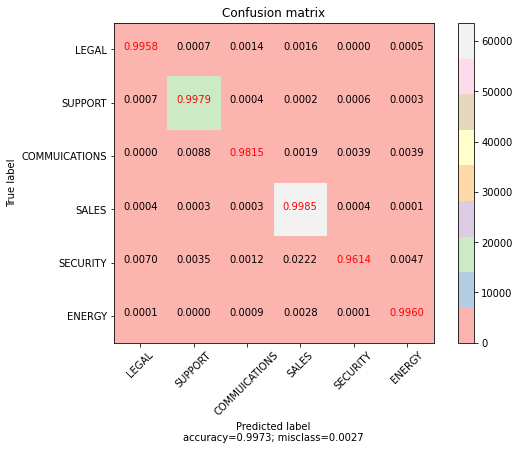

In [41]:
z= df_val[LABEL_COLUMN].unique()
lookup = {0: 'LEGAL', 1:'COMMUICATIONS', 2:'SECURITY', 3:'SUPPORT', 4:'ENERGY', 5:'SALES'}
plot_confusion_matrix(cm,[lookup[_] for _ in z])

In [42]:
#Finally, let’s take a pretend email, create a crude data scrubbing function and feed it through our model’s predictor:

subject_to_predict = "Help, sketchy email"
content_to_predict = "Yassine sent me a risky email, offending me with how noodles are unhealthy for you and i should eat more apples in order to get a better GPA in school, is this spam?"

In [45]:
def scrub_text(subject_to_predict, content_to_predict, departments):
  # prep text
  subject_to_predict = subject_to_predict.lower()
  pattern = re.compile('[^a-z]')
  subject_to_predict = re.sub(pattern, ' ', subject_to_predict)
  pattern = re.compile('\s+')
  subject_to_predict = re.sub(pattern, ' ', subject_to_predict) 
  
  content_to_predict = content_to_predict.lower()
  pattern = re.compile('[^a-z]')
  content_to_predict = re.sub(pattern, ' ', content_to_predict)
  pattern = re.compile('\s+')
  content_to_predict = re.sub(pattern, ' ', content_to_predict) 
  
  # get bag-of-words
  words_groups = []
  text = subject_to_predict + ' ' + content_to_predict
  for group_id in range(len(departments)):
    work_group = []
    print('Working bag number:', str(group_id))
    top_words = departments[group_id]
    work_group.append(len([w for w in text.split() if w in set(top_words)]))
    words_groups.append(work_group)

  # count emails per category group and feature engineering
  raw_text = []
  subject_length = []
  subject_word_count = []
  content_length = []
  content_word_count = []
  is_am_list = []
  is_weekday_list = []
  group_LEGAL = []
  group_COMMUICATIONS = []
  group_SECURITY_SPAM_ALERTS = []
  group_SUPPORT = []
  group_ENERGY_DESK = []
  group_SALES_DEPARTMENT = []
  final_outcome = []

  cur_time_stamp = datetime.datetime.now()
 
  raw_text.append(text)
  group_LEGAL.append(words_groups[0])
  group_COMMUICATIONS.append(words_groups[1]) 
  group_SECURITY_SPAM_ALERTS.append(words_groups[2])
  group_SUPPORT.append(words_groups[3])
  group_ENERGY_DESK.append(words_groups[4])
  group_SALES_DEPARTMENT.append(words_groups[5])
  outcome_tots = [words_groups[0], words_groups[1], words_groups[2], words_groups[3], words_groups[4], words_groups[5]] 
  final_outcome.append(outcome_tots.index(max(outcome_tots)))
    
  subject_length.append(len(subject_to_predict))
  subject_word_count.append(len(subject_to_predict.split()))
  content_length.append(len(content_to_predict))
  content_word_count.append(len(content_to_predict.split()))
  dt = cur_time_stamp
  is_am = 'no'
  if (dt.time() < datetime.time(12)): is_am = 'yes'
  is_am_list.append(is_am)
  is_weekday = 'no'
  if (dt.weekday() < 6): is_weekday = 'yes'
  is_weekday_list.append(is_weekday)
 
  # add simple engineered features?
  training_set = pd.DataFrame({
                "raw_text":raw_text,
                "group_LEGAL":group_LEGAL[0],
                "group_COMMUICATIONS":group_COMMUICATIONS[0],
                "group_SECURITY_SPAM_ALERTS":group_SECURITY_SPAM_ALERTS[0],
                "group_SUPPORT":group_SUPPORT[0],
                "group_ENERGY_DESK":group_ENERGY_DESK[0],
                "group_SALES_DEPARTMENT":group_SALES_DEPARTMENT[0],
                "subject_length":subject_length,
                "subject_word_count":subject_word_count,
                "content_length":content_length,
                "content_word_count":content_word_count,
                "is_AM":is_am_list,
                "is_weekday":is_weekday_list,
                "outcome":final_outcome})


  return(training_set)

In [46]:
import re

scrubbed_entry = scrub_text(subject_to_predict, content_to_predict, departments)

Working bag number: 0
Working bag number: 1
Working bag number: 2
Working bag number: 3
Working bag number: 4
Working bag number: 5


In [47]:

y_pred = classifier.predict(input_fn=(lambda: input_fn(scrubbed_entry)))
y_pred2 = next(y_pred)


department_names = ['Legal Desk', 'Communications Desk', 'Security Desk', 'Help Desk', 'Energy Desk', 'Sales Desk']

print('Forward request to: ' +  department_names[y_pred2['class_ids'][0]])


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpitlimkyz/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Forward request to: Security Desk
